In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

In [25]:
# for environ
import os

# only using device 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

# importing tensorflow
import tensorflow as tf

# import scipy
import scipy, csv

In [3]:
!rm iris.csv
!wget https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv

--2019-03-07 23:02:07--  https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3858 (3.8K) [text/plain]
Saving to: ‘iris.csv’

iris.csv            100%[===================>]   3.77K  --.-KB/s    in 0s      

2019-03-07 23:02:07 (111 MB/s) - ‘iris.csv’ saved [3858/3858]



Using feedforward fully-connected neural network with input size 28^2, 5 layers (28^2-40-40-30-30-10-1), 10-dim output (classification). Using MNIST as data. Using optimizers: SGD, Adam. Plotting spectra of the hessian after convergence. Using 10 repetitions of the experiment.

In [546]:
# loading mnist
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


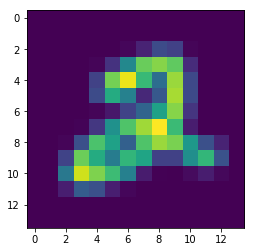

In [558]:
plt.imshow(scipy.misc.imresize(x_train[5], (14, 14)))

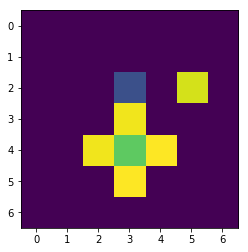

In [543]:
plt.imshow(x_train[9])

In [26]:
tf.reset_default_graph()
# allowing GPU memory growth to allocate only what we need
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
sess = tf.Session(config=config, graph = tf.get_default_graph())

In [27]:
iris = list(csv.reader(open('iris.csv')))[1:]

# The inputs are four floats: sepal length, sepal width, petal length, petal width.
inputs  = np.array(iris)[:,:4].astype(np.float)

In [28]:
outputs = np.array(iris)[:,4]
# Convert the output strings to ints.
outputs_vals, outputs_ints = np.unique(outputs, return_inverse=True)

In [29]:
# Split the input and output data sets into training and test subsets.
inds = np.random.permutation(len(inputs))
train_inds, test_inds = np.array_split(inds, 2)
x_train, y_train = inputs[train_inds], outputs_ints[train_inds]
x_test,  y_test  = inputs[test_inds],  outputs_ints[test_inds]

In [30]:
# input data: batch w h channels
x = tf.placeholder(tf.float32, shape = (None, 4), name = 'input')

# output labels (vector)
y = tf.placeholder(tf.int64, shape = (None,), name = 'labels')

# one-hot encoded labels
y_one_hot = tf.one_hot(y, 3)

In [31]:
def fc_layer(x, n, activation = tf.nn.sigmoid):
    """ Fully connected layer for input x and output dim n """
    return tf.contrib.layers.fully_connected(x, n, activation_fn=activation,
    weights_initializer=tf.initializers.lecun_normal(), weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(), biases_regularizer=None, trainable=True)

In [32]:
# flatten w * h
l0 = tf.contrib.layers.flatten(x)

# layers
with tf.name_scope('layers'):
    z = l0
    z = fc_layer(z, 10)
    z = fc_layer(z, 5)
    z = fc_layer(z, 3, activation = None)
    output = z

# softmax to make probability distribution
logits = tf.nn.softmax(output)

# predicted labels
labels = tf.argmax(logits, axis = 1)

# loss: cross-entropy
loss = tf.losses.softmax_cross_entropy(y_one_hot, logits)

# accuracy of predictions
accuracy = tf.contrib.metrics.accuracy(labels, y)

In [33]:
# list of all parameters
params = tf.trainable_variables()#tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

In [34]:
# gradients of the loss
grads = tf.gradients(loss, params)

In [35]:
# gamma (learning rate)
gamma = tf.placeholder(tf.float32, shape = ())

In [36]:
def decrement_weights(W, gamma, grads):
    """ w = w - how_much """
    ops = [w.assign(tf.subtract(w, tf.multiply(gamma, grad))) for w, grad in zip(W, grads)]
    return tf.group(ops)

In [37]:
# perform gradient descent step
train_op = decrement_weights(params, gamma, grads)

In [38]:
def epoch(gamma_ = 0.1):
    # do the training
    train_loss, train_acc, _ = sess.run([loss, accuracy, train_op], feed_dict = {x: x_train, y: y_train, gamma: gamma_})

    # compute accuracy and loss
    test_loss, test_acc = sess.run([loss, accuracy], feed_dict = {x: x_test, y: y_test})

    # saving data
    metrics['train_loss'] += [train_loss]
    metrics['test_loss'] += [test_loss]
    metrics['train_acc'] += [train_acc]
    metrics['test_acc'] += [test_acc]

In [39]:
# metrics to compute
metrics = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

# initializing weights...
init = tf.global_variables_initializer()
sess.run(init)

In [40]:
for i in tqdm(range(1, 2000)):
    epoch((2000. - i) / 10000)

100%|██████████| 1999/1999 [00:02<00:00, 912.92it/s]


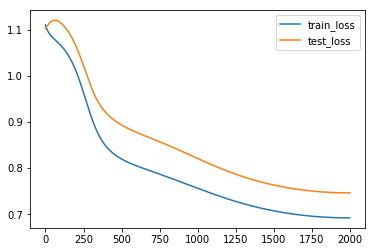

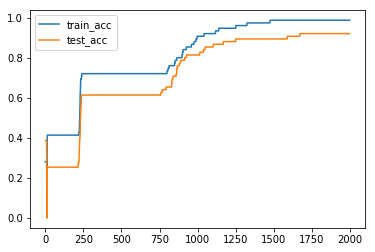

In [41]:
plt.figure()
plt.plot(metrics['train_loss'], label = 'train_loss')
plt.plot(metrics['test_loss'], label = 'test_loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(metrics['train_acc'], label = 'train_acc')
plt.plot(metrics['test_acc'], label = 'test_acc')
plt.legend()
plt.show()

In [42]:
print('Total parameters:', np.sum([np.prod(p.shape) for p in params]))

Total parameters: 123


In [43]:
def dz_dw_flatten(z):
    """ Calculate dz/dparams and flatten the result """
    return tf.concat([tf.reshape(x, shape = (-1,)) for x in tf.gradients(z, params)], axis = 0)

In [44]:
def iterate_flatten(tensor):
    if type(tensor) == list:
        for t in tensor:
            for v in iterate_flatten(t):
                yield v
    elif len(tensor.shape) == 0:
        yield tensor
    else:
        for idx in range(tensor.shape[0]):
            for v in iterate_flatten(tensor[idx]):
                yield v

In [45]:
grad_components = list(iterate_flatten(grads))

In [46]:
hessian = [dz_dw_flatten(t) for t in tqdm(grad_components)]

100%|██████████| 123/123 [00:12<00:00,  7.23it/s]


In [51]:
H = sess.run(hessian, feed_dict = {x: x_train, y: y_train})

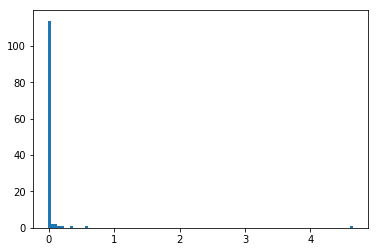

In [58]:
plt.hist(np.linalg.eig(H)[0], bins = 100)
plt.show()

In [161]:
tf.gradients(loss, params)

[<tf.Tensor 'gradients_5/layers/fully_connected/MatMul_grad/MatMul_1:0' shape=(4, 50) dtype=float32>,
 <tf.Tensor 'gradients_5/layers/fully_connected/BiasAdd_grad/BiasAddGrad:0' shape=(50,) dtype=float32>,
 <tf.Tensor 'gradients_5/layers/fully_connected_1/MatMul_grad/MatMul_1:0' shape=(50, 10) dtype=float32>,
 <tf.Tensor 'gradients_5/layers/fully_connected_1/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'gradients_5/layers/fully_connected_2/MatMul_grad/MatMul_1:0' shape=(10, 3) dtype=float32>,
 <tf.Tensor 'gradients_5/layers/fully_connected_2/BiasAdd_grad/BiasAddGrad:0' shape=(3,) dtype=float32>]